### Business context

### Understanding collaborative filtering and dataset

![alt text](collaborative_filtering.png "User Item Interactions")

`we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>    

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
df=pd.read_csv("ratings_small.csv")



In [3]:
# observe the head of the dataset

df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


in this dataset, the variable `timestamp` is not helpful to build this recommendation system, so we can delete this variable from our dataset

In [5]:
# remove the variable timestamp from the dataset

df.drop("timestamp",axis=1,inplace=True)

### Exploring the dataset

In [6]:
# see the shape of the dataset

df.shape

(100004, 3)

In [8]:
# check for missing values

df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [9]:
# total number of unique users

df.nunique()

userId      671
movieId    9066
rating       10
dtype: int64

In [35]:
# which user has rated the most

#df.groupby("userId")["userId"].sum().sort_values(ascending=False).index[0]
df["userId"].value_counts().index[0]

547

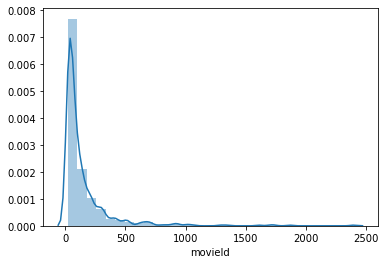

In [69]:
# create a histogram of all the interactions by all the users present in the dataset
'''Tells that data is Righly skewed, so less number of users have interacted with
high number of movies, and many users have interacted with few movies only'''
sns.distplot(df.groupby("userId").count()["movieId"],bins=30)



### Creating user item matrix

Creating user item interactions matrix

In [46]:
# create the user item matrix using the ratings dataset - Hint: try using pivot function 
interactions_df=pd.pivot(df,index="userId",columns="movieId",values="rating")


In [47]:
# check the shape of the matrix

interactions_df.shape

(671, 9066)

In [48]:
# check head of the matrix and see how it looks like

interactions_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# replace all the missing values with zero

interactions_df=interactions_df.fillna(0)

### TFinding similar users

In [58]:
# import cosine_similarity from sklearn
from sklearn.metrics.pairwise import cosine_similarity

def similar_users(user_id, interactions_matrix):
    
    # compute similarity of each user to the provided user
    similarity=[]
    for user in range(1,interactions_matrix.shape[0]+1):
        sim=cosine_similarity([interactions_matrix.loc[user_id]],[interactions_matrix.loc[user]])
        similarity.append((user,sim))
    # sort by similarity
    similarity.sort(key=lambda x:x[1],reverse=True)
    
    # create list of just the user ids
    similar_users=[x[0] for x in similarity]
    
    # create list of similarity score
    similar_scores=[x[1] for x in similarity]
    
    # remove the user's own id
    similar_users.remove(user_id)
    
    # remove the user's own similarity score
    similar_scores.remove(similar_scores[0])
       
    return similar_users,similar_scores

In [61]:
# check the implemented function above

similar_users(564,interactions_df)[0][:5]

[306, 102, 518, 232, 119]

In [62]:
similar_users(564,interactions_df)[1][:5]

[array([[0.4752071]]),
 array([[0.45945837]]),
 array([[0.45806577]]),
 array([[0.42648819]]),
 array([[0.42188474]])]

### Creating similarity based collaborative recommendation system

In [65]:
def recommendations(user_id, num_of_movies, user_item_interactions):
    # find the most similar users to the user_id for which we want to recommend movies
    most_similar_users=similar_users(user_id,user_item_interactions)[0]
    # find out those movies which this user has already interacted with
    movie_id=set(list(user_item_interactions.columns[np.where(user_item_interactions.loc[user_id]>0)]))
    # create an empty list to store the recommended movies
    recommendations=[]
    # copy those movies which are already interacted by user_id
    already_interacted=movie_id.copy()
    # loop through each similar user from the list of most_similar_users
    for similar_user in most_similar_users:    
        # implement the below code till the length of recommended movies does not become equal to num_of_movies
        if (len(recommendations)<num_of_movies):
            # store all the movies interacted by each similar user to user_id
            similar_user_movie_ids=set(list(user_item_interactions.columns[np.where(user_item_interactions.loc[similar_user]>0)]))
            # add those movies in the recommended list which are present in similar_user_movie_ids but not present in already_interacted
            recommendations.extend(list(similar_user_movie_ids.difference(already_interacted)))
            # now add all those movies into already_interacted which we already added in recommendations
            already_interacted=already_interacted.union(similar_user_movie_ids)
        else:
            break
    
    return recommendations[:num_of_movies]

In [68]:
# check the implemented function above
'''These are the recommended movie ids which are not yet watched by userId'''
recommendations(564,3,interactions_df)



[1537, 515, 1027]

In [1]:
# For any new user who haven't interacted yet with anything. We can recommend top three movies to the new user

#for a new user recommend top 3 movies
#movies["movie_id"].value_counts()[:3]